# QIT: Homework Lecture 6

Taking $X \sim \mathrm{Unif}([0,1,2,3])$, $|\mathcal{Y}| = |\mathcal{X}| = 4$.  
For every random variable realization $x$ we use **three parallel quantum channels** such that:

$$
\rho_{X B^3}
= \sum_x p_X(x)\, |x\rangle\langle x|_X \otimes |\psi_x\rangle\langle \psi_x|_{B^3},
$$

where

$$
|\psi_0\rangle_{B^3} = |\theta_0\rangle_B \otimes |\theta_0\rangle_B \otimes |\theta_0\rangle_B
$$

$$
|\psi_1\rangle_{B^3} = |\theta_0\rangle_B \otimes |\theta_1\rangle_B \otimes |\theta_1\rangle_B
$$

$$
|\psi_2\rangle_{B^3} = |\theta_1\rangle_B \otimes |\theta_0\rangle_B \otimes |\theta_1\rangle_B
$$

$$
|\psi_3\rangle_{B^3} = |\theta_1\rangle_B \otimes |\theta_1\rangle_B \otimes |\theta_0\rangle_B.
$$

and

$$
|\theta_0\rangle = 
\begin{bmatrix}
\cos\frac{\theta}{2} \\
\sin\frac{\theta}{2}
\end{bmatrix}
\;;\;
|\theta_1\rangle =
\begin{bmatrix}
\cos\frac{\theta}{2} \\
-\sin\frac{\theta}{2}
\end{bmatrix}
$$


A POVM is applied to the $B^3$ part to get $Y$:

$$
\rho_{XY}
= \sum_{x,y} p_X(x)\, |x\rangle\langle x|_X \otimes \mathrm{tr}\{\Lambda_y |\psi_x\rangle\langle\psi_x|^{B^3}\}\, |y\rangle\langle y|_Y
$$

$$
= \sum_{x,y} p_X(x)\, p_{Y|X}(y|x)\, |x\rangle\langle x|_X \otimes |y\rangle\langle y|_Y.
$$

The *square-root measurement* POVM is the optimal one:

$$
\Lambda_y = \frac{1}{4} \, (\rho_{B^3})^{-1/2}\, |\psi_y\rangle\langle\psi_y|\; (\rho_{B^3})^{-1/2},
\qquad y \in \{0,1,2,3\},
$$

and where

$$
\rho_{B^3} = \mathrm{tr}_X \{\rho_{X B^3}\}.
$$

Since $\rho_{B^3}$ is not full rank, the inverse operation should be replaced by the pseudo-inverse.


In [31]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

# Functions for creating theta and codewords
def calculate_ket_theta(theta, sub: int):
    if sub in [0, 1]:
        return np.array([[np.cos(theta/2)], [(-1)**sub * np.sin(theta/2)]], dtype=complex)
    else:
        raise ValueError("sub index must be 0 or 1")
    
def build_codewords(theta):
    """Return list [psi0, psi1, psi2, psi3], each an 8x1 column vector."""
    ket0 = calculate_ket_theta(theta, 0)
    ket1 = calculate_ket_theta(theta, 1)

    def kron3(a, b, c):
        return np.kron(np.kron(a, b), c)

    psi0 = kron3(ket0, ket0, ket0)
    psi1 = kron3(ket0, ket1, ket1)
    psi2 = kron3(ket1, ket0, ket1)
    psi3 = kron3(ket1, ket1, ket0)

    return [psi0, psi1, psi2, psi3]


# Function for creating the mixed state
def build_rho_B3(psi_list):
    """psi_list is [psi0, psi1, psi2, psi3]; each psi is 8x1."""
    d = psi_list[0].shape[0]
    rho = np.zeros((d, d), dtype=complex)
    for psi in psi_list:
        rho += psi @ psi.conj().T # |psi><psi|
    rho /= 4.0
    return rho

# Function for computing the von Neumann entropy using eigenvalues
def von_neumann_entropy(rho, tol=1e-12):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > tol]
    return float(-np.sum(eigvals * np.log2(eigvals)))


# Function for computing rho^(-1/2) by-CHATGPT
def rho_inv_sqrt(rho, tol=1e-10):
    """Return the pseudo-inverse square root of rho."""
    eigvals, eigvecs = np.linalg.eigh(rho)
    inv_sqrt_vals = np.zeros_like(eigvals)
    for i, lam in enumerate(eigvals):
        if lam > tol:
            inv_sqrt_vals[i] = 1.0 / np.sqrt(lam)
        else:
            inv_sqrt_vals[i] = 0.0
    D_inv_sqrt = np.diag(inv_sqrt_vals)
    return eigvecs @ D_inv_sqrt @ eigvecs.conj().T


# Function for building the optimal POVM
def build_povm(psi_list, rho_B3):
    """Return list [Lambda0,...,Lambda3]."""
    num_psi = len(psi_list)
    rho_isqrt = rho_inv_sqrt(rho_B3)
    povm = []
    for psi in psi_list:
        proj = psi @ psi.conj().T   # |psi><psi|
        Lambda = (1.0 / num_psi) * (rho_isqrt @ proj @ rho_isqrt)
        povm.append(Lambda)
    return povm

# Function for calculating the Accesible Information I(X;B)
def compute_accessible_information(psi_list, povm, tol=1e-12):
    """Compute I3(X;Y) for uniform X over {0,1,2,3}."""
    num_x = len(psi_list)
    num_y = len(povm)
    p_x = 1.0 / num_x

    # Conditional probabilities p(y|x)
    p_y_given_x = np.zeros((num_x, num_y), dtype=float)
    for x, psi in enumerate(psi_list):
        for y, Lambda in enumerate(povm):
            amp = psi.conj().T @ (Lambda @ psi)     # <psi|Lambda|psi>
            p_y_given_x[x, y] = np.real(amp[0, 0]) 

    # Joint and marginal probabilities
    p_xy = p_x * p_y_given_x    # p(x,y) = p(x)*p(y|x)
    p_y = p_xy.sum(axis=0)      # p(y) = sum_x p(x,y)

    # Mutual information
    I = 0.0
    for x in range(num_x):
        for y in range(num_y):
            if p_xy[x, y] > tol and p_y[y] > tol:
                I += p_xy[x, y] * np.log2(p_xy[x, y] / (p_x * p_y[y]))
    return float(I)

def compute_I3_curves(theta_min=1e-3, theta_max=np.pi, num_points=314):
    theta_vals = np.linspace(theta_min, theta_max, num_points)
    I3_XY_vals = []
    I3_XB3_vals = []

    for theta in theta_vals:
        # 1) Codewords
        psi_list = build_codewords(theta)

        # 2) Rho_B3 and quantum MI
        rho_B3 = build_rho_B3(psi_list)
        I3_XB3 = von_neumann_entropy(rho_B3)

        # 3) POVM and accessible info
        povm = build_povm(psi_list, rho_B3)
        I3_XY = compute_accessible_information(psi_list, povm)

        I3_XB3_vals.append(I3_XB3)
        I3_XY_vals.append(I3_XY)

    return theta_vals, np.array(I3_XY_vals), np.array(I3_XB3_vals)

def compute_I_curves(theta_min=1e-3, theta_max=np.pi, num_points=314):
    theta_vals = np.linspace(theta_min, theta_max, num_points)
    I_XY_vals = []
    I_XB_vals = []
    def x_log2_x(x):
        """Compute x * log2(x) with the convention that 0 * log2(0) = 0."""
        results = np.zeros_like(x)
        mask = x > 0 # only calculate log where x > 0
        results[mask] = x[mask] * np.log2(x[mask])
        return results

    def h2(x):
        """Compute the binary entropy function h2(x) = -x*log2(x) - (1-x)*log2(1-x)."""
        return - x_log2_x(x) - x_log2_x(1 - x)

    for theta in theta_vals:
        # Accessible information I(X,Y)
        h2_term = h2((1-np.sin(theta))/2)

        InfoXY = 1 - h2_term

        # Mutual information I(X,B)
        cos_term = np.cos(theta/2)**2
        sin_term = np.sin(theta/2)**2

        InfoXB = - x_log2_x(cos_term) - x_log2_x(sin_term)

        I_XB_vals.append(InfoXB)
        I_XY_vals.append(InfoXY)

    return theta_vals, np.array(I_XY_vals), np.array(I_XB_vals)


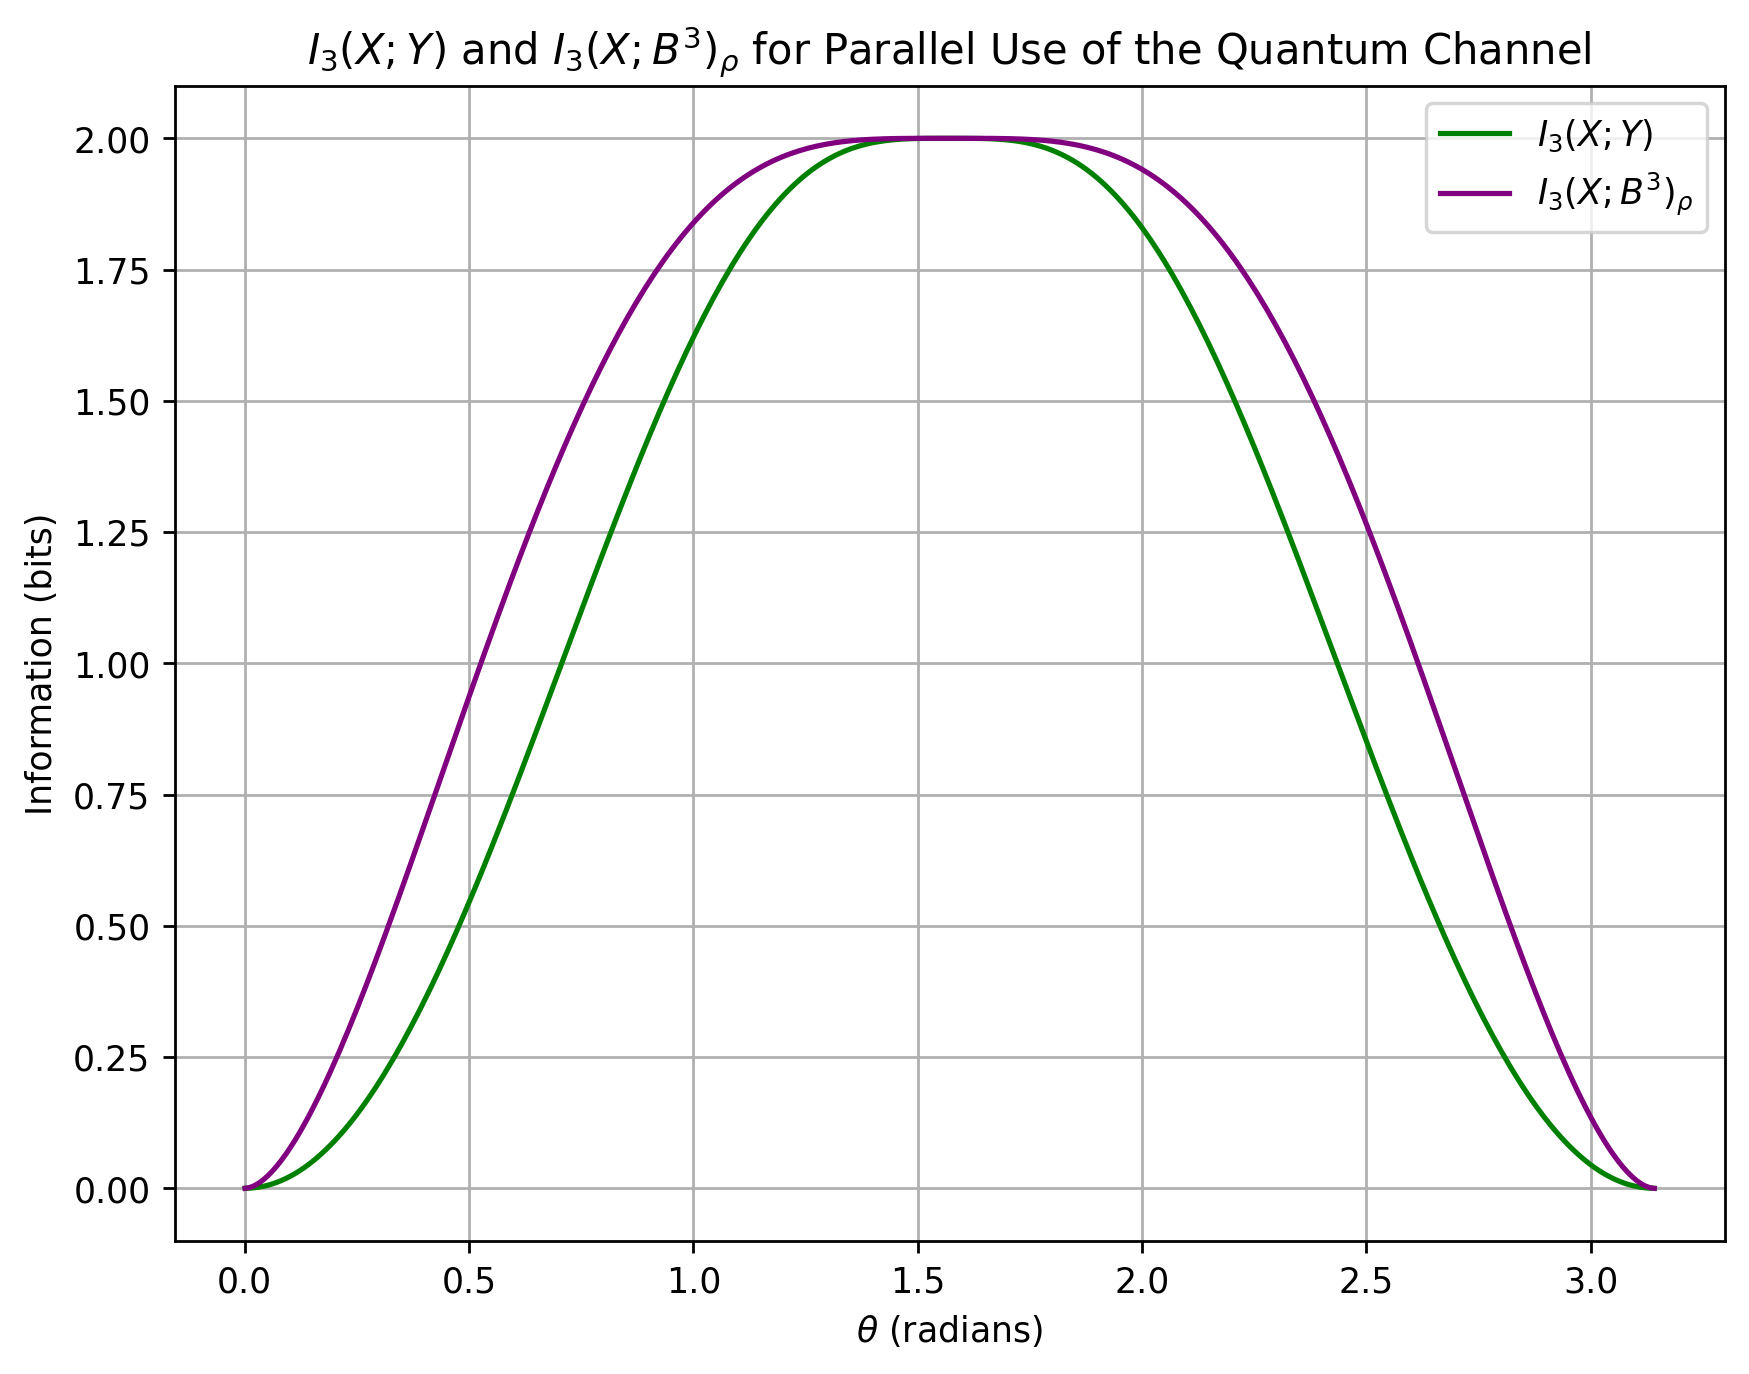

In [51]:
theta_vals, I3_XY_vals, I3_XB3_vals = compute_I3_curves()

plt.figure(figsize=(8, 6), dpi=250)
plt.plot(theta_vals, I3_XY_vals, label=r'$I_3(X;Y)$', color='green')
plt.plot(theta_vals, I3_XB3_vals, label=r'$I_3(X;B^3)_\rho$', color='purple')
plt.xlabel(r'$\theta$ (radians)')
plt.ylabel('Information (bits)')
plt.title(r'$I_3(X;Y)$ and $I_3(X;B^3)_\rho$ for Parallel Use of the Quantum Channel')
plt.legend()
plt.grid()
plt.show()


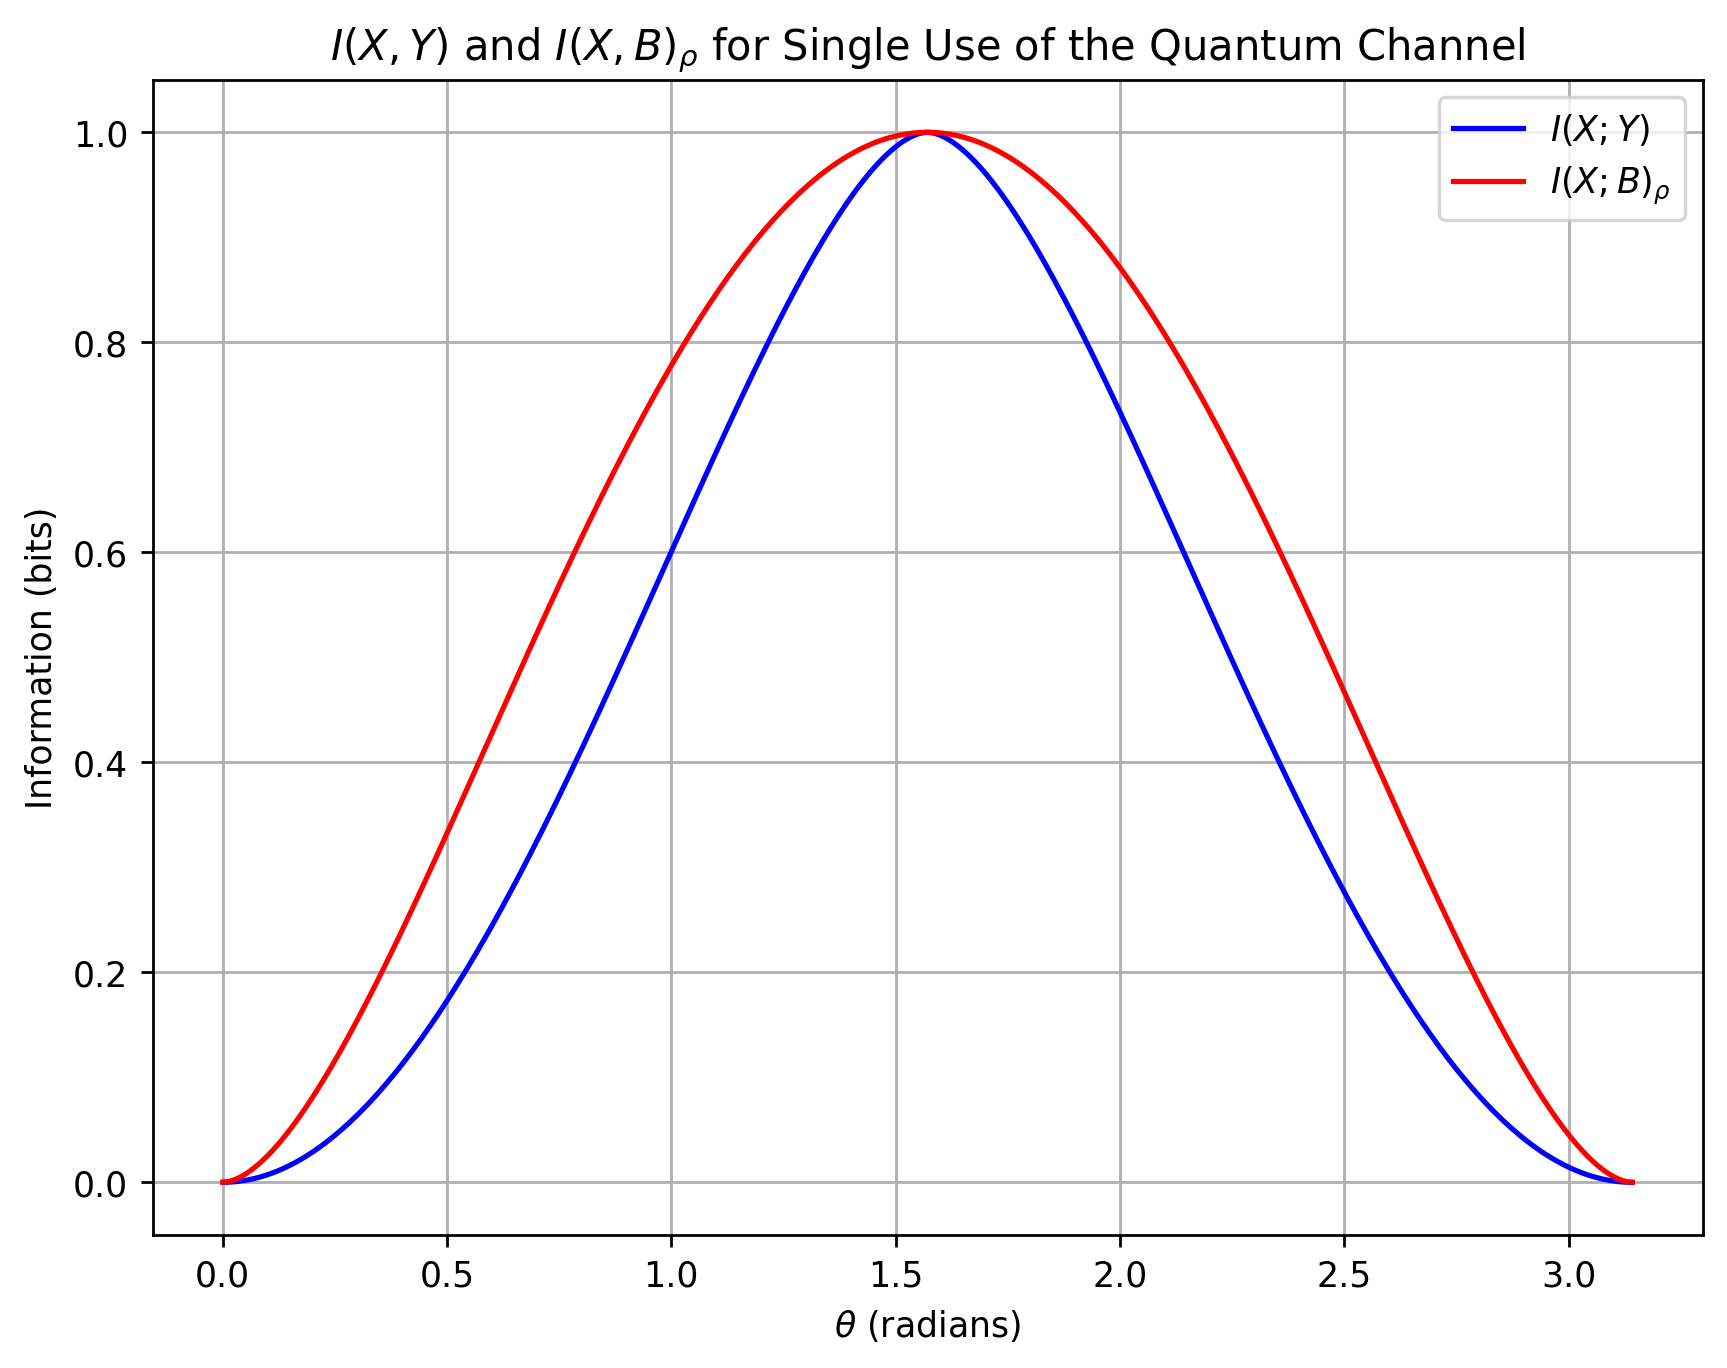

In [52]:
theta_vals, I_XY_vals, I_XB_vals = compute_I_curves()

plt.figure(figsize=(8, 6), dpi=250)
plt.plot(theta_vals, I_XY_vals, label=r'$I(X;Y)$', color='blue')
plt.plot(theta_vals, I_XB_vals, label=r'$I(X;B)_\rho$', color='red')
plt.xlabel(r'$\theta$ (radians)')
plt.ylabel('Information (bits)')
plt.title(r'$I(X,Y)$ and $I(X,B)_\rho$ for Single Use of the Quantum Channel')
plt.legend()
plt.grid()
plt.show()


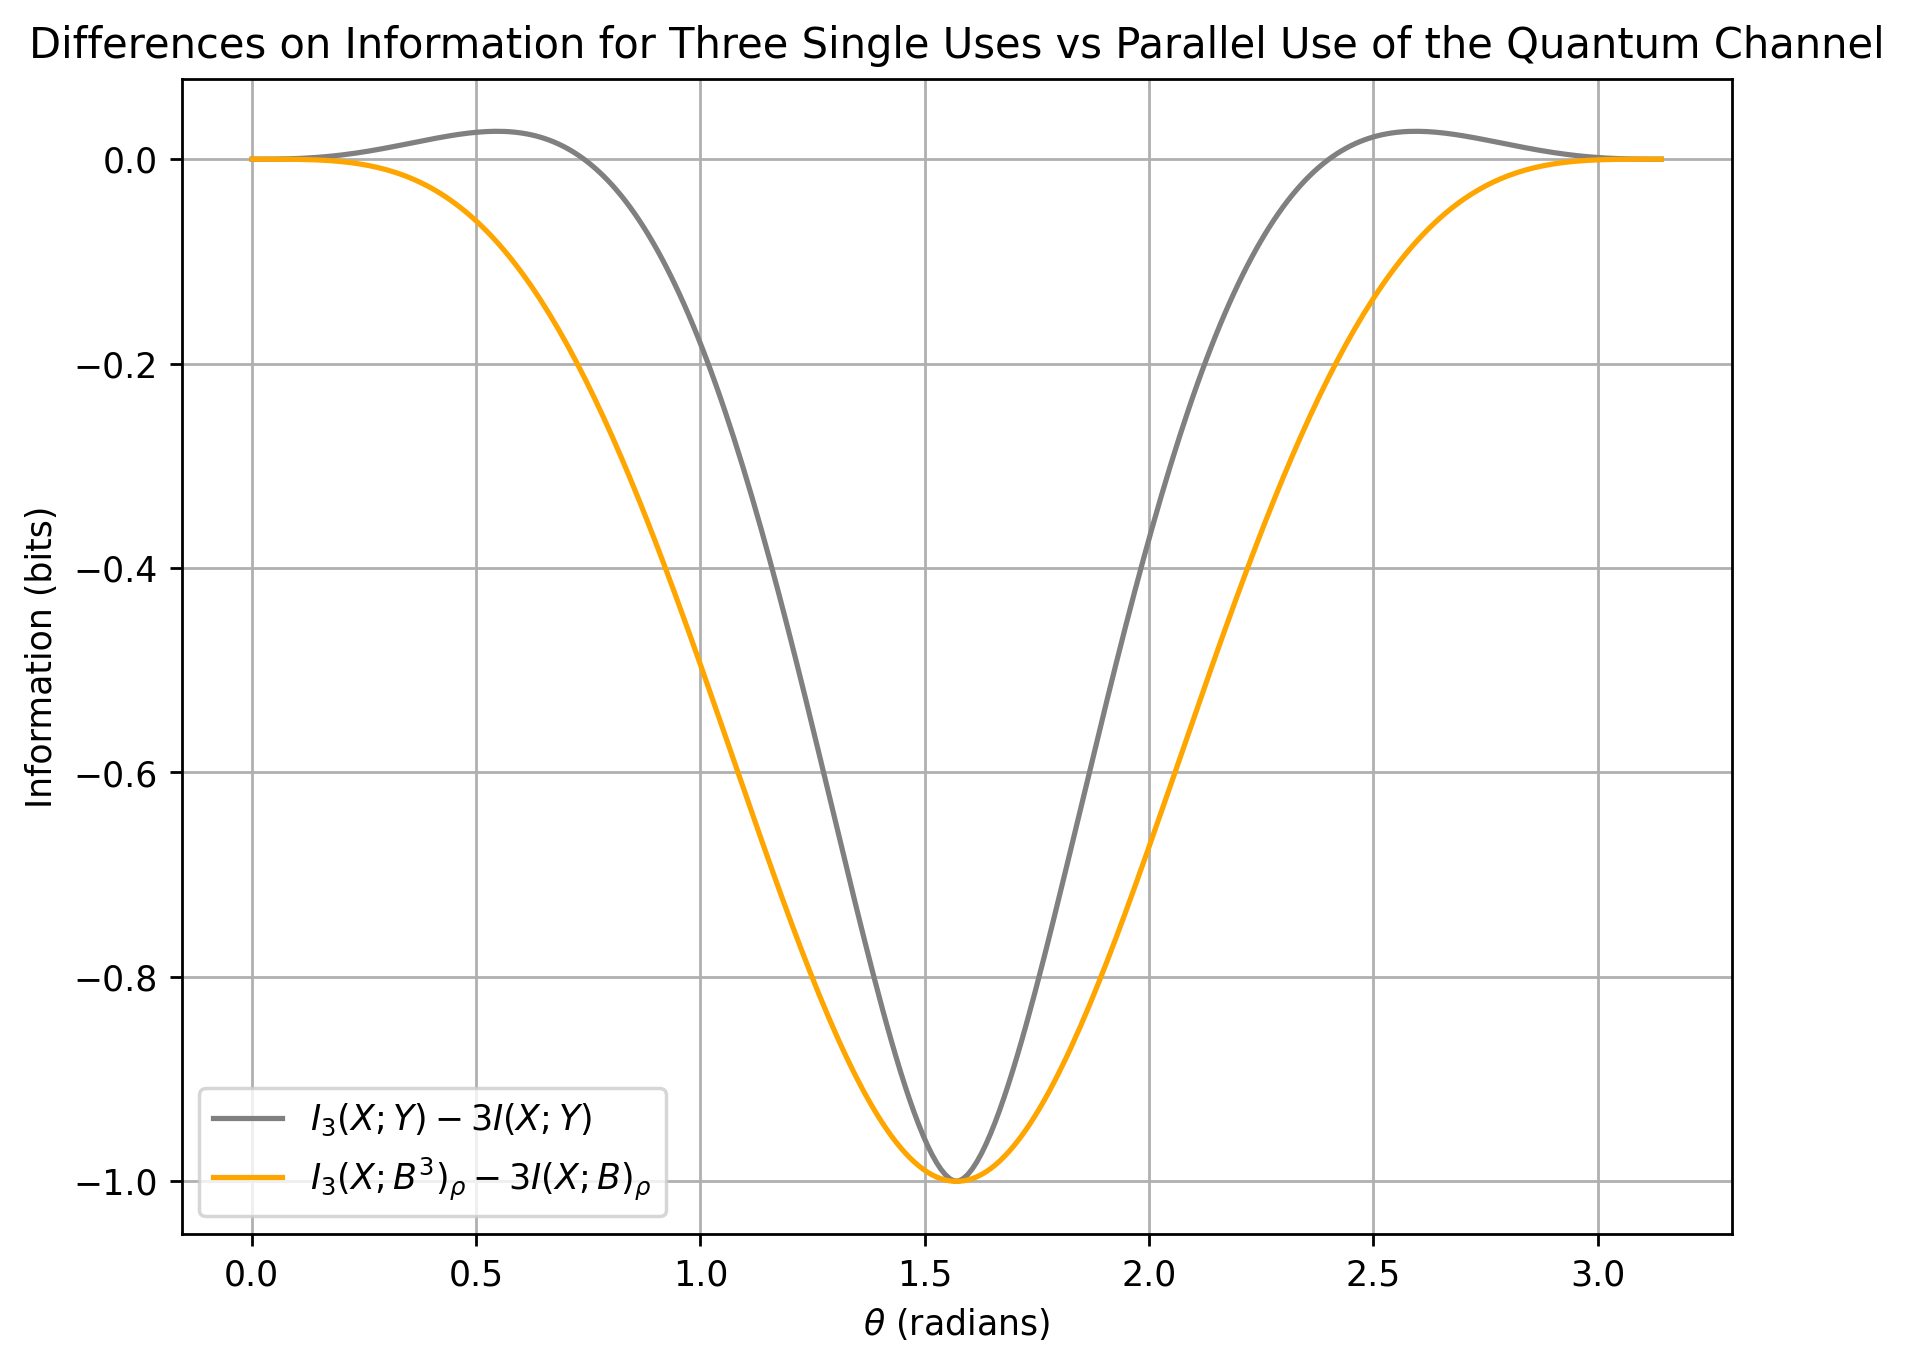

In [53]:
plt.figure(figsize=(8, 6), dpi=250)
plt.plot(theta_vals, I3_XY_vals - 3*I_XY_vals, label=r'$I_3(X;Y) - 3 I(X;Y)$', color='gray')
plt.plot(theta_vals, I3_XB3_vals - 3*I_XB_vals, label=r'$I_3(X;B^3)_\rho - 3I(X;B)_\rho$', color='orange')
plt.xlabel(r'$\theta$ (radians)')
plt.ylabel('Information (bits)')
plt.title(r'Differences on Information for Three Single Uses vs Parallel Use of the Quantum Channel')
plt.legend()
plt.grid()
plt.show()